In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [3]:
PATH = ("/kaggle/input/playground-series-s3e3")

In [4]:
train = pd.read_csv(PATH + "/train.csv")
test = pd.read_csv (PATH + "/test.csv")
sample_sub = pd.read_csv(PATH + "/sample_submission.csv")

In [5]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample Submission shape: {sample_sub.shape}")

Train shape: (1677, 35)
Test shape: (1119, 34)
Sample Submission shape: (1119, 2)


In [6]:
train.sample(5)

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
1072,1072,47,Travel_Rarely,1283,Research & Development,1,4,Technical Degree,1,3,...,80,2,8,3,3,8,7,0,1,0
428,428,29,Travel_Rarely,1300,Research & Development,7,2,Medical,1,3,...,80,1,7,2,3,7,4,0,5,0
1160,1160,31,Travel_Rarely,135,Research & Development,6,3,Life Sciences,1,3,...,80,0,9,4,2,9,3,7,8,0
188,188,31,Travel_Frequently,990,Research & Development,6,5,Medical,1,2,...,80,3,7,4,3,4,2,0,3,0
1212,1212,49,Travel_Rarely,989,Research & Development,6,3,Medical,1,4,...,80,1,23,2,3,8,7,7,7,0


In [7]:
train.columns

Index(['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition'],
      dtype='object')

In [8]:
train.isna().sum().sum() # There are no null values in the dataset

0

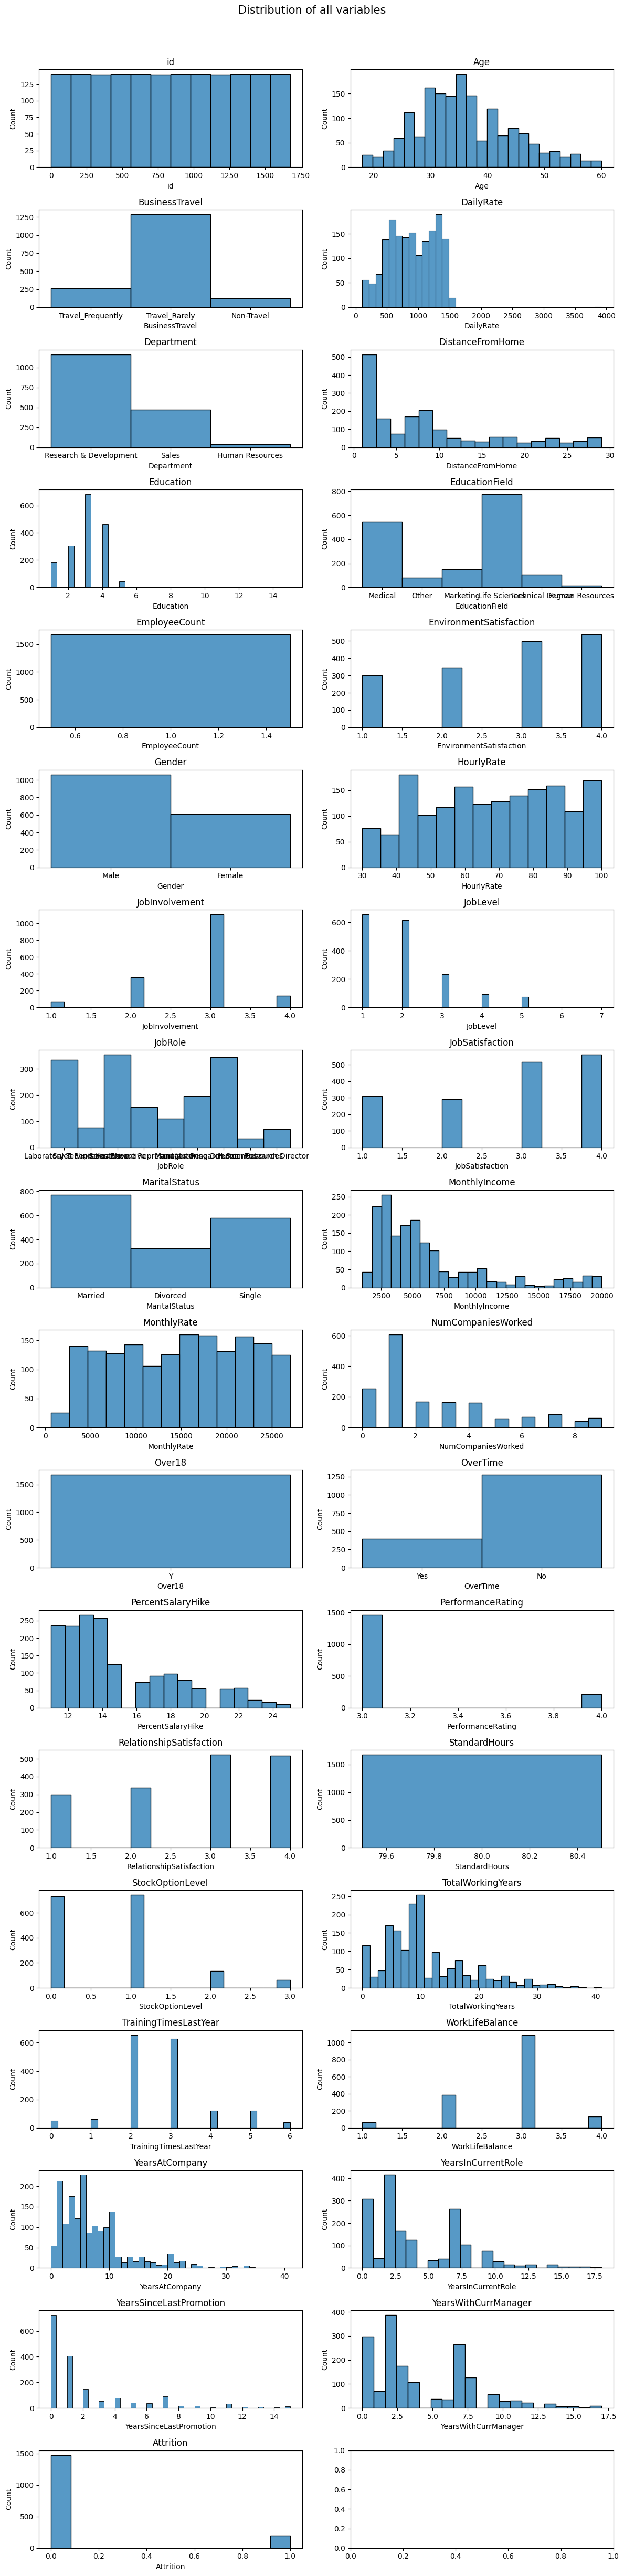

In [9]:
# Source: Phong NGuyen (https://www.kaggle.com/code/phongnguyen1/s3e3-from-eda-to-final-submission)

fig, axs = plt.subplots(nrows= np.ceil(len(train.columns)/2).astype(int), ncols=2, figsize=(12, 50))

for column, ax in zip(train.columns, axs.flatten()):
    sns.histplot(train[column], ax=ax)
    ax.set_title(column)

fig.suptitle('Distribution of all variables', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [11]:
# I'll check how values of type 'Object' look
object_columns = ["BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus",
                  "Over18","OverTime"]

In [12]:
print("------------------------------------------------------------------------------")
for i in train[object_columns].columns:
    print(f"{i}: {train[i].unique()}")
    print("------------------------------------------------------------------------------")
# "Over18" is just "Y", so i can drop that

------------------------------------------------------------------------------
BusinessTravel: ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
------------------------------------------------------------------------------
Department: ['Research & Development' 'Sales' 'Human Resources']
------------------------------------------------------------------------------
EducationField: ['Medical' 'Other' 'Marketing' 'Life Sciences' 'Technical Degree'
 'Human Resources']
------------------------------------------------------------------------------
Gender: ['Male' 'Female']
------------------------------------------------------------------------------
JobRole: ['Laboratory Technician' 'Sales Representative' 'Sales Executive'
 'Healthcare Representative' 'Manager' 'Manufacturing Director'
 'Research Scientist' 'Human Resources' 'Research Director']
------------------------------------------------------------------------------
MaritalStatus: ['Married' 'Divorced' 'Single']
-------------------

In [13]:
train.drop("Over18", axis = 1, inplace = True)

In [14]:
print(train.columns, train.shape)

Index(['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object') (1677, 34)


In [15]:
train.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


In [16]:
train["Attrition"].value_counts()

Attrition
0    1477
1     200
Name: count, dtype: int64

In [17]:
train["StandardHours"].value_counts() #StandardHours is just "80", i can drop that too

StandardHours
80    1677
Name: count, dtype: int64

In [18]:
train.drop("StandardHours", axis = 1, inplace = True)

In [19]:
train.shape

(1677, 33)

In [20]:
train["EmployeeCount"].value_counts() # Just "1"

EmployeeCount
1    1677
Name: count, dtype: int64

In [21]:
train.drop("EmployeeCount",axis = 1, inplace = True )

In [22]:
# I'm dropping the columns also from the test set
test.drop(["Over18","StandardHours","EmployeeCount"], axis = 1, inplace = True)

In [23]:
print(train.shape, test.shape)

(1677, 32) (1119, 31)


In [24]:
train["Attrition"]

0       0
1       0
2       0
3       0
4       1
       ..
1672    0
1673    0
1674    1
1675    0
1676    0
Name: Attrition, Length: 1677, dtype: int64

In [25]:
X = train.drop("Attrition", axis = 1)
y = train["Attrition"]
X_test = test

In [26]:
X.shape, y.shape, X_test.shape

((1677, 31), (1677,), (1119, 31))

In [27]:
cat_cols = [col for (col, d) in zip(X.columns,X.dtypes) if d == "object"]
cat_cols

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [28]:
# 
X = pd.get_dummies(X, dtype = float)
X_test = pd.get_dummies(X_test, dtype = float)

In [29]:
X.drop("id", axis = 1, inplace = True)
X_test.drop("id", axis = 1, inplace = True)

In [30]:
X_test.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,19,992,1,1,4,43,3,1,3,2318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,45,1136,4,4,3,67,3,2,1,5486,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,37,155,13,3,4,41,3,1,4,2741,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,32,688,1,4,3,89,2,2,3,5228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,29,464,9,1,3,79,3,1,4,1223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) 

In [32]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()

In [33]:
X_pca = pca.fit_transform(X)
X_pca_df = pd.DataFrame(X_pca) 

In [34]:
X_pca_df.sample()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
1669,-1.670733,-1.112346,-0.882821,2.115856,-1.732141,1.281386,0.160328,0.671996,1.07446,1.496928,...,-0.003322,0.093489,0.014985,-8.079957e-17,-1.092730e-16,7.569275e-17,5.921712e-18,2.486361e-16,-9.942456e-17,-2.839723e-16


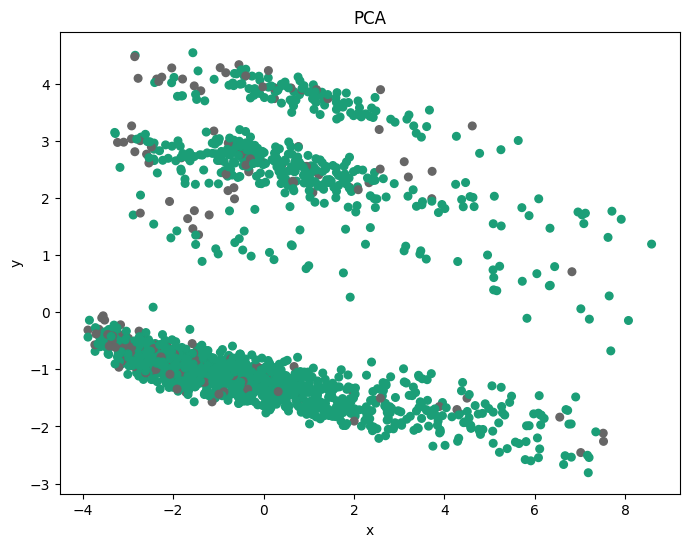

In [35]:
plt.figure(figsize = (8,6))
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1],c = y,  cmap = "Dark2", s=30)
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

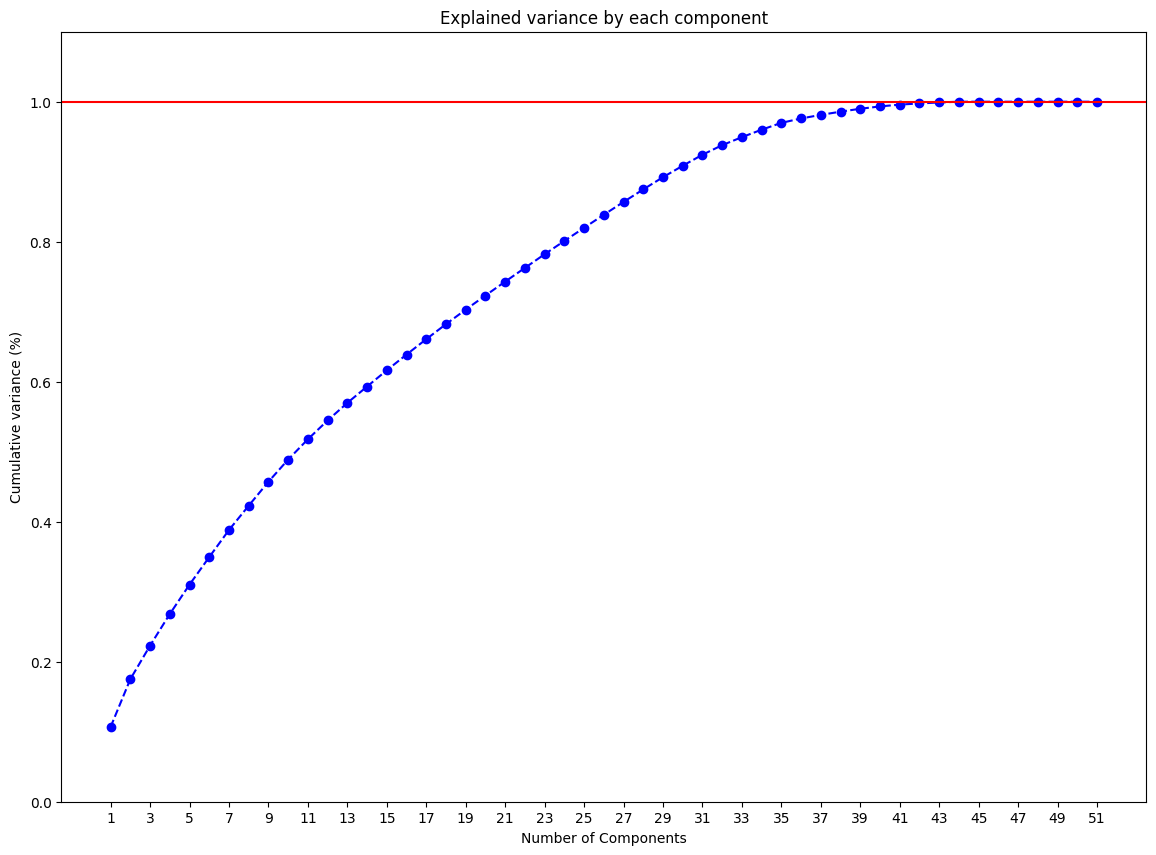

In [36]:
# Source : Samuel Cortinhas (https://www.kaggle.com/code/samuelcortinhas/ps-s3e3-hill-climbing-like-a-gm)

plt.figure(figsize=(14,10))
xi = np.arange(1,1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0,1.1)
plt.xlabel("Number of Components")
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.grid(False)

plt.show()

In [37]:
models = {
    'LogisticRegression' : LogisticRegression(random_state= 5 ),
    'XGBoost' : XGBClassifier(),
    'CatBoost' : CatBoostClassifier(verbose=0),
    'LGBM' : LGBMClassifier(),
    'GradientBoosting' : GradientBoostingClassifier(),
    'RandomForest' : RandomForestClassifier(random_state = 5),
    #'KNN' : KNeighborsClassifier()
}

In [38]:
LR_grid = {'penalty': ['l1','l2'],
           "solver": ["liblinear"],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

In [39]:
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
}

In [40]:
for clf, model in models.items():
    model.fit(X, y)
    print(f"{clf} completed")

LogisticRegression completed
XGBoost completed
CatBoost completed
LGBM completed
GradientBoosting completed
RandomForest completed


In [41]:
res = {}

k_fold = KFold(n_splits= 10)

for clf, model in models.items():
    result = np.mean(cross_val_score(model, X, y, scoring= 'roc_auc', cv = k_fold))
    res[clf] = result

In [42]:
for clf, score in res.items():
    print("-----------------------------------------")
    print(f'{clf} score: {score}')

-----------------------------------------
LogisticRegression score: 0.8136061362172878
-----------------------------------------
XGBoost score: 0.7976952817708832
-----------------------------------------
CatBoost score: 0.8331139201441852
-----------------------------------------
LGBM score: 0.8099899518776035
-----------------------------------------
GradientBoosting score: 0.8126351711727665
-----------------------------------------
RandomForest score: 0.8219090973081375


In [43]:
pred = models['CatBoost'].predict_proba(X_test)[:, 1]

In [44]:
test_id = test["id"]

In [45]:
submisson = pd.DataFrame({'id': test_id, 'Attrition': pred})
submisson.to_csv('submisson.csv', index = None)